# **This code is working**

In [8]:
import os.path as osp
from typing import Callable, Optional
import torch
import torch_geometric

from torch_geometric.data import InMemoryDataset, TemporalData, download_url
import pandas as pd
import matplotlib.pyplot as plt



class ICEWS18Dataset(InMemoryDataset):
    r"""The temporal knowledge graph dataset from the ICEWS18 benchmark dataset,
    which combines train, validation, and test files into a single dataset.

    Args:
        root (str): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before being saved to
            disk. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - Name
          - #entities
          - #relations
          - #events
        * - ICEWS18
          - varies
          - varies
          - varies
    """
    url = 'https://github.com/INK-USC/RE-Net/raw/master/data/ICEWS18'

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        super().__init__(root, transform, pre_transform, force_reload=force_reload)
        self.load(self.processed_paths[0], data_cls=TemporalData)

    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, 'ICEWS18', 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, 'ICEWS18', 'processed')

    @property
    def raw_file_names(self) -> list:
        # List of files to download and process
        return ['train.txt', 'valid.txt', 'test.txt']

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        # Download each file separately
        for file_name in self.raw_file_names:
            download_url(f"{self.url}/{file_name}", self.raw_dir)

    def process(self) -> None:

        # List to hold DataFrames for each file
        dfs = []
            # List to hold DataFrames for each file

        for file_name in self.raw_file_names:
            file_path = osp.join(self.raw_dir, file_name)
            df = pd.read_csv(file_path, sep='\t', header=None, usecols=[0, 1, 2, 3],
                            names=['src', 'relation', 'dst', 'timestamp'])

            dfs.append(df)

            # Draw histograms for each column
          # columns = ['src', 'relation', 'dst', 'timestamp']

          # for column in columns:
          #     plt.figure(figsize=(8, 5))
          #     plt.hist(df[column], bins=30, alpha=0.7, edgecolor='black')
          #     plt.title(f'Histogram of {column}')
          #     plt.xlabel(column)
          #     plt.ylabel('Frequency')
          #     plt.grid(axis='y', alpha=0.75)
          #     plt.show()

        # Concatenate all dataframes into a single dataframe
        full_df = pd.concat(dfs, ignore_index=True)
        print(f"Total events (triples) in combined dataset: {len(full_df)}")

        # Process columns for temporal data
        src = torch.tensor(full_df['src'].values, dtype=torch.long)
        dst = torch.tensor(full_df['dst'].values, dtype=torch.long)
        #relation = torch.tensor(full_df['relation'].values, dtype=torch.float).tolist()
        relation = torch.tensor(full_df['relation'].values, dtype=torch.float).view(-1, 1)

        timestamp = torch.tensor(full_df['timestamp'].values, dtype=torch.long)

        print("\nTensor shapes:")
        print(f"src: {src.shape}")
        print(f"dst: {dst.shape}")
        print(f"t: {timestamp.shape}")
        print(f"msg: {relation.shape}")

        # Create the TemporalData object
        data = TemporalData(src=src, dst=dst, t=timestamp, msg=relation)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        # Print debug information about the data object
        print("Data object before saving:")
        print(f"  - Number of source nodes (src): {data.src.size(0)}")
        print(f"  - Number of destination nodes (dst): {data.dst.size(0)}")
        print(f"  - Number of timestamps (t): {data.t.size(0)}")
        print(f"  - Number of relations (msg): {data.msg.size(0)}")

        # Save the processed data
        self.save([data], self.processed_paths[0])


    def __repr__(self) -> str:
        return 'ICEWS18()'

In [9]:
dataset = ICEWS18Dataset(root='./data/')
data = dataset[0]  # Access the single TemporalData object

# Calculate statistics based on the TemporalData object directly
num_events = data.src.size(0)
unique_src_nodes = set(data.src.tolist())
unique_dst_nodes = set(data.dst.tolist())
# unique_relations = set(data.msg.tolist())
unique_timestamps = set(data.t.tolist())
unique_nodes = unique_src_nodes.union(unique_dst_nodes)
num_nodes = len(unique_nodes)

# Print dataset statistics
print("\nDataset Statistics:")
print(f"Number of events (triples): {num_events}")
print(f"Number of unique nodes: {num_nodes}")
print(f"Number of unique source nodes: {len(unique_src_nodes)}")
print(f"Number of unique destination nodes: {len(unique_dst_nodes)}")
# print(f"Number of unique relations: {len(unique_relations)}")
print(f"Number of unique timestamps: {len(unique_timestamps)}")


Using existing file train.txt


Total events (triples) in combined dataset: 419435

Tensor shapes:
src: torch.Size([419435])
dst: torch.Size([419435])
t: torch.Size([419435])
msg: torch.Size([419435, 1])
Data object before saving:
  - Number of source nodes (src): 419435
  - Number of destination nodes (dst): 419435
  - Number of timestamps (t): 419435
  - Number of relations (msg): 419435

Dataset Statistics:
Number of events (triples): 419435
Number of unique nodes: 15197
Number of unique source nodes: 12973
Number of unique destination nodes: 11711
Number of unique timestamps: 245


Processing...
Done!
/home/melike/anaconda3/envs/myenv2/lib/python3.10/site-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.

In [10]:
import os.path as osp
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv, GCNConv
from torch_geometric.nn.dense import dense_diff_pool
from torch_geometric.utils import to_dense_adj, to_dense_batch
from torch_geometric.nn.models.tgn import IdentityMessage, LastAggregator, LastNeighborLoader
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


data = dataset[0].to(device)


# Split dataset into train/val/test
train_data, val_data, test_data = data.train_val_test_split(val_ratio=0.15, test_ratio=0.15)

print("train date")
print("Source nodes:", train_data.src)
print("Destination nodes:", train_data.dst)
print("Number of edges:", train_data.src.size(0))
print("======")
print("test date")
print("Source nodes:", test_data.src)
print("Destination nodes:", test_data.dst)
print("Number of edges:", test_data.src.size(0))
print("======")
print("val date")
print("Source nodes:", val_data.src)
print("Destination nodes:", val_data.dst)
print("Number of edges:", val_data.src.size(0))
print("======")

if train_data.src.numel() == 0 or train_data.dst.numel() == 0:
    print("Edge information is empty. Check data loading or preprocessing.")
else:
    print("Edges are present.")


print("Sample edges (src -> dst):")
for i in range(min(10, train_data.src.size(0))):
    print(f"{train_data.src[i].item()} -> {train_data.dst[i].item()}")


# Count edges for each node
unique_nodes, edge_counts = torch.cat([train_data.src, train_data.dst]).unique(return_counts=True)
print("Nodes and their edge counts:", list(zip(unique_nodes.tolist(), edge_counts.tolist())))



# Print the size and number of events in each split
print(f'Number of events in each split:')
print(f'  - Train: {train_data.num_events}')
print(f'  - Validation: {val_data.num_events}')
print(f'  - Test: {test_data.num_events}')


# Initialize TemporalDataLoader for each dataset split
train_loader = TemporalDataLoader(train_data, batch_size=512, neg_sampling_ratio=1.0)
val_loader = TemporalDataLoader(val_data, batch_size=512, neg_sampling_ratio=1.0)
test_loader = TemporalDataLoader(test_data, batch_size=512, neg_sampling_ratio=1.0)

# Initialize LastNeighborLoader for neighborhood sampling
neighbor_loader = LastNeighborLoader(num_nodes=data.num_nodes, size=10, device=device)

# Checking batches in the data loader
# print('====================')
# batch_count = 0  # Initialize a counter
# print('Check batches in dataloader')
# for batch in train_loader:
#     print(f"Batch {batch_count + 1}:")
#     print(batch)  # Check the contents of the batch
#     print(batch.src, batch.dst, batch.t, batch.msg)  # Access batch attributes
#     batch_count += 1  # Increment the counter
#     if batch_count == 2:  # Stop after two batches
#         break

# print('===================')
print('Print neighbor loader')

# Get all unique node IDs from 'src' and 'dst' attributes of your data
all_node_ids = torch.cat([train_data.src, train_data.dst]).unique()

# Pass these unique node IDs to the neighbor loader
n_id, edge_index, e_id = neighbor_loader(all_node_ids)

# Print the shapes and some values
# print(n_id.shape, edge_index.shape, e_id.shape)
# print(n_id[:10], edge_index[:, :10], e_id[:10])  # Print some values



##check msg size
# print("data msg size")
# print(data.msg.size())
# print(data.msg.shape)

# print(f"data.msg shape: {data.msg.shape} (Expected: [total_num_edges, msg_dim])")
# print(f"data.msg example values: {data.msg[:5]}")  # Print a few example values to inspect


train date
Source nodes: tensor([  2,   2, 103,  ...,   4, 198, 198], device='cuda:0')
Destination nodes: tensor([ 26,  54,  82,  ..., 198,   4,  27], device='cuda:0')
Number of edges: 294139
test date
Source nodes: tensor([21787,  5717,   948,  ...,   221,   265,   221], device='cuda:0')
Destination nodes: tensor([ 5717, 21787, 21787,  ...,   265,   221,  5394], device='cuda:0')
Number of edges: 61925
val date
Source nodes: tensor([    3,   844,    93,  ...,   259,  8179, 11750], device='cuda:0')
Destination nodes: tensor([134, 197,  91,  ..., 260,  57,  50], device='cuda:0')
Number of edges: 63371
Edges are present.
Sample edges (src -> dst):
2 -> 26
2 -> 54
103 -> 82
5 -> 60
60 -> 5
5 -> 265
265 -> 5
2 -> 16
2 -> 0
2 -> 70
Nodes and their edge counts: [(0, 40900), (1, 18719), (2, 17733), (3, 10275), (4, 9579), (5, 9369), (6, 9564), (7, 9179), (8, 7711), (9, 6651), (10, 6282), (11, 5299), (12, 5579), (13, 4967), (14, 4624), (15, 3047), (16, 3723), (17, 3725), (18, 2386), (19, 3596), 

Epoch 1/150
Epoch :01
Loss: 1.5153
Validation AP: 0.9527, Validation AUC: 0.9469, Validation MRR: 0.9708
Test AP: 0.9409, Test AUC: 0.9321, Test MRR: 0.9631
Learning rate: 0.0001
Epoch 1 completed in 33.19s
Epoch 2/150
Epoch :02
Loss: 1.3742
Validation AP: 0.9554, Validation AUC: 0.9493, Validation MRR: 0.9714
Test AP: 0.9432, Test AUC: 0.9349, Test MRR: 0.9630
Learning rate: 0.0001
Epoch 2 completed in 33.53s
Epoch 3/150
Epoch :03
Loss: 1.3607
Validation AP: 0.9562, Validation AUC: 0.9503, Validation MRR: 0.9715
Test AP: 0.9447, Test AUC: 0.9368, Test MRR: 0.9638
Learning rate: 0.0001
Epoch 3 completed in 33.43s
Epoch 4/150
Epoch :04
Loss: 1.3527
Validation AP: 0.9566, Validation AUC: 0.9507, Validation MRR: 0.9715
Test AP: 0.9462, Test AUC: 0.9382, Test MRR: 0.9638
Learning rate: 0.0001
Epoch 4 completed in 33.65s
Epoch 5/150
Epoch :05
Loss: 1.3475
Validation AP: 0.9573, Validation AUC: 0.9513, Validation MRR: 0.9713
Test AP: 0.9466, Test AUC: 0.9385, Test MRR: 0.9638
Learning rate: 

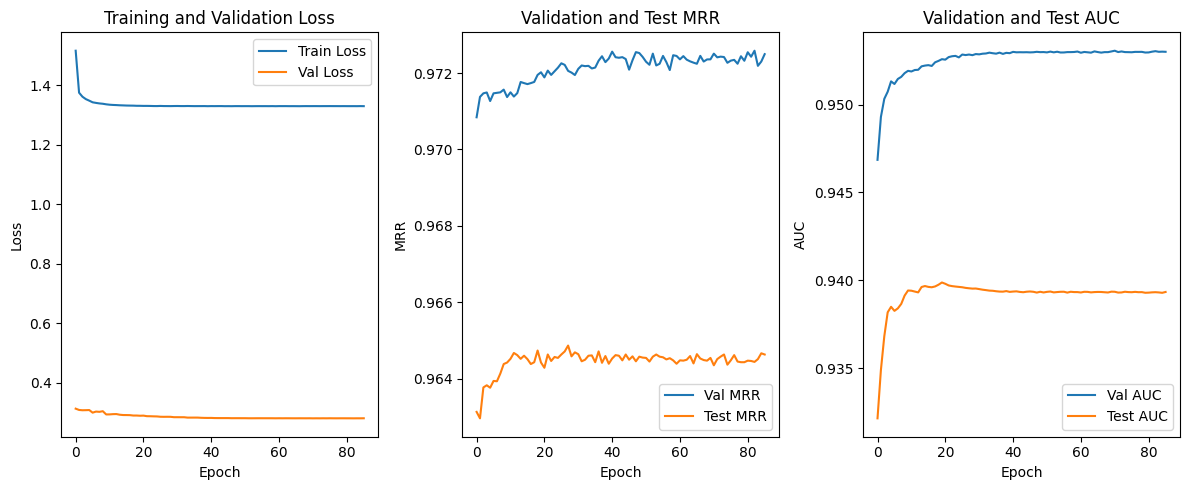

In [12]:
# Utility function for optional debugging output
def debug_shapes(**shapes):
    for name, value in shapes.items():
        print(f"{name} shape: {value.shape}")


class DiffPoolLayer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_nodes, ratio=0.25):
        super().__init__()
        self.num_clusters = max(1, int(ratio * num_nodes))
        self.gnn_embed = GCNConv(in_channels, hidden_channels)
        self.gnn_pool = GCNConv(in_channels, self.num_clusters)
        self.bn = torch.nn.BatchNorm1d(hidden_channels) # Add batch normalization here


    def forward(self, x, edge_index, batch, debug=False):
        embed = self.gnn_embed(x, edge_index)
        embed = self.bn(embed)  # Add batch normalization here
        s = self.gnn_pool(x, edge_index).softmax(dim=-1)

        # Convert to dense batch
        x, mask = to_dense_batch(embed, batch)
        adj = to_dense_adj(edge_index, batch)
        s, _ = to_dense_batch(s, batch)

        if debug:
            debug_shapes(x=x, adj=adj, s=s)

        # Differential pooling
        x, adj, link_loss, ent_loss = dense_diff_pool(x, adj, s, mask, normalize=True)
        x = x.view(-1, x.size(-1))  # Flatten the output if necessary

        return x, adj, link_loss, ent_loss


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2, dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        # print("Debugging GraphAttentionEmbedding:")
        # print(f"  x shape: {x.shape}")
        # print(f"  last_update shape: {last_update.shape}")
        # print(f"  edge_index shape: {edge_index.shape}")
        # print(f"  t shape: {t.shape}")
        # print(f"  msg shape: {msg.shape}")
        # print(f"  edge_index content: {edge_index}")
        # print(f"  edge_attr content before conv: {torch.cat([self.time_enc(last_update[edge_index[0]] - t.to(x.dtype)), msg], dim=-1)}")


        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class FeatureFusion(torch.nn.Module):
    def __init__(self, tgn_dim, diffpool_dim, output_dim):
        super().__init__()
        self.tgn_projection = Linear(tgn_dim, output_dim)
        self.diffpool_projection = Linear(diffpool_dim, output_dim)
        self.attention = torch.nn.MultiheadAttention(embed_dim=output_dim, num_heads=4, batch_first=True)
        self.final_projection = Linear(output_dim, output_dim)

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, tgn_features, diffpool_features):
        # tgn_proj = self.tgn_projection(tgn_features)
        # diffpool_proj = self.diffpool_projection(diffpool_features)
        tgn_proj = self.dropout(self.tgn_projection(tgn_features))
        diffpool_proj = self.dropout(self.diffpool_projection(diffpool_features))

        diffpool_proj = F.interpolate(diffpool_proj.unsqueeze(0).unsqueeze(0),
                                      size=(tgn_proj.size(0), diffpool_proj.size(1)),
                                      mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        combined = tgn_proj + diffpool_proj
        attended, _ = self.attention(combined.unsqueeze(0), combined.unsqueeze(0), combined.unsqueeze(0))
        return self.final_projection(attended.squeeze(0))


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = (self.lin_src(z_src) * self.lin_dst(z_dst)).relu()
        return self.lin_final(h)


# Model dimensions
memory_dim = time_dim = embedding_dim = 100
hidden_dim = 64
final_dim = 128


# print("data msg size")
# print(data.msg.size())
# print(data.msg.shape)

# print(f"data.msg shape: {data.msg.shape} (Expected: [total_num_edges, msg_dim])")
# print(f"data.msg example values: {data.msg[:5]}")  # Print a few example values to inspect

# Initialize models
memory = TGNMemory(data.num_nodes, data.msg.size(-1), memory_dim, time_dim,
                   message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
                   aggregator_module=LastAggregator()).to(device)

# print("Initializing GraphAttentionEmbedding with the following parameters:")
# print(f"  memory_dim (in_channels): {memory_dim} (Expected: integer, dimension size for input features)")
# print(f"  embedding_dim (out_channels): {embedding_dim} (Expected: integer, dimension size for output features)")
# print(f"  Message dimension (data.msg.size(-1)): {data.msg.size(-1)} (Expected: integer, size of each message embedding)")
# print(f"  Time encoder (memory.time_enc): {memory.time_enc} (Expected: instance of TimeEncoder or similar)")


gnn = GraphAttentionEmbedding(memory_dim, embedding_dim, data.msg.size(-1), memory.time_enc).to(device)

diffpool = DiffPoolLayer(memory_dim, hidden_dim, data.num_nodes, ratio=0.3).to(device)

fusion = FeatureFusion(embedding_dim, hidden_dim, final_dim).to(device)

link_pred = LinkPredictor(final_dim).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(list(memory.parameters()) + list(gnn.parameters()) +
                             list(diffpool.parameters()) + list(fusion.parameters()) +
                             list(link_pred.parameters()), lr=0.0001, weight_decay=1e-4)

criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0], device=device))

# Helper vector for node mapping
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)



def process_batch(batch, debug=False):
    # Loading neighbors and setting up the association vector
    # print("\nLoading neighbors for batch...")
    n_id, edge_index, e_id = neighbor_loader(batch.n_id)
    # print(f"e_id shape: {e_id.shape} (Expected: 1D tensor with indices)")
    # print(f"e_id content: {e_id[:10]}")  # Print the first few indices for inspection


    # Updating association vector
    assoc[n_id] = torch.arange(n_id.size(0), device=device)


    # Initializing batch_vector
    batch_vector = torch.zeros(n_id.size(0), dtype=torch.long, device=device)


    # TGN Embedding
    z, last_update = memory(n_id)

    # print("Debugging inputs to GraphAttentionEmbedding forward pass:")
    # print(f"  z shape: {z.shape} (Expected: [num_nodes, memory_dim])")
    # print(f"  last_update shape: {last_update.shape} (Expected: [num_nodes])")
    # print(f"  edge_index shape: {edge_index.shape} (Expected: [2, num_edges])")
    # print(f"  data.t[e_id].shape: {data.t[e_id].to(device).shape} (Expected: [num_edges])")
    # print(f"  data.msg[e_id].shape: {data.msg[e_id].to(device).shape} (Expected: [num_edges, msg_dim])")
    # print(f"e_id shape: {e_id.shape} (Expected: 1D tensor with indices)")
    # print(f"e_id content: {e_id[:10]}")  # Print the first few indices for inspection
    # print(f"data.msg[e_id].shape: {data.msg[e_id].shape}")
    # print(f"data.msg[e_id] example values: {data.msg[e_id][:5]}")  # Inspect a few values if needed


    z_tgn = gnn(z, last_update, edge_index, data.t[e_id].to(device), data.msg[e_id].to(device))


    # DiffPool Embedding
    # print("\nGenerating DiffPool embedding...")
    z_diffpool, adj_diffpool, link_loss, ent_loss = diffpool(z, edge_index, batch_vector, debug=debug)
    # print("DiffPool output z_diffpool:", z_diffpool)
    # print("DiffPool output adj_diffpool:", adj_diffpool)
    # print("Link loss:", link_loss)
    # print("Entropy loss:", ent_loss)

    # Feature Fusion
    # print("\nFusing TGN and DiffPool features...")
    z_combined = fusion(z_tgn, z_diffpool)
    # print("Combined feature vector z_combined:", z_combined)
    return z_combined, link_loss, ent_loss


def train_epoch():
   # Set models to training mode and confirm

    memory.train()
    gnn.train()
    diffpool.train()
    fusion.train()
    link_pred.train()
    memory.reset_state()
    neighbor_loader.reset_state()

    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        #print(f"Processing batch {batch_idx + 1}...")  # Print the batch number (1-based index)

        # if batch.edge_index.size(1) == 0:  # Skip batch if no edges are present
        #     print("Skipping empty batch.")
        #     continue
        # else:
        #     print(f"Processing batch {batch_idx + 1} with {batch.edge_index.size(1)} edges.")

        optimizer.zero_grad()
        batch = batch.to(device)

        z_combined, link_loss, ent_loss = process_batch(batch, debug=False)
        pos_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.dst]])
        neg_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.neg_dst]])

        # Debugging: Print positive and negative scores
        # print("Positive Scores (pos_out):", pos_out[:5].detach().cpu().numpy())
        # print("Negative Scores (neg_out):", neg_out[:5].detach().cpu().numpy())

        # Debugging: Visualize score distributions
        # plt.hist(pos_out.detach().cpu().numpy(), bins=50, alpha=0.5, label="Positive Scores")
        # plt.hist(neg_out.detach().cpu().numpy(), bins=50, alpha=0.5, label="Negative Scores")
        # plt.legend()
        # plt.title("Distribution of Positive and Negative Scores")
        # plt.show()

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))
        loss += 0.1 * (link_loss + ent_loss)

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events

# def calculate_mrr(pos_out, neg_out):
#     # Combine scores
#     all_scores = torch.cat([pos_out, neg_out], dim=0)
#     labels = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)
#     labels = labels.to(all_scores.device)

#     # Step 2: Debugging label distribution
#     print("Labels (1=Positive, 0=Negative):", labels.detach().cpu().numpy())
#     print(f"Number of Positive Labels: {torch.sum(labels == 1).item()}")
#     print(f"Number of Negative Labels: {torch.sum(labels == 0).item()}")

#     # Sort scores and labels
#     sorted_indices = torch.argsort(all_scores, descending=True)
#     sorted_labels = labels[sorted_indices]

#     # Step 3: Debugging sorted results
#     print("All Scores (sorted):", all_scores[sorted_indices][:10].detach().cpu().numpy())
#     print("Sorted Labels (top 10):", sorted_labels[:10].detach().cpu().numpy())

#     ranks = torch.where(sorted_labels == 1)[0] + 1  # Convert to 1-based rank
#     if ranks.size(0) == 0:
#         print("No positive labels found in sorted labels!")
#         return 0.0

#     # reciprocal_ranks = 1.0 / ranks.float()
#     ranks = torch.where(sorted_labels == 1)[0] + 1
#     print(f"Ranks of Positive Samples: {ranks.cpu().numpy()}")
#     reciprocal_ranks = 1.0 / ranks.float()
#     print(f"Reciprocal Ranks: {reciprocal_ranks.cpu().numpy()}")

#     return reciprocal_ranks.mean().item()

def calculate_mrr(pos_score, neg_score):
    """
    Calculate Mean Reciprocal Rank (MRR) for a batch of queries.
    Args:
        pos_score: Tensor of shape [batch_size, 1], scores for positive examples.
        neg_score: Tensor of shape [batch_size, num_negatives], scores for negative examples.
    Returns:
        MRR score (float)
    """
    # Validate input shapes
    if pos_score.size(0) != neg_score.size(0):
        raise ValueError("pos_score and neg_score must have the same batch size.")

    # Combine positive and negative scores for ranking
    scores = torch.cat([pos_score, neg_score], dim=1)  # Shape: [batch_size, 1 + num_negatives]

    # Create binary labels (1 for positive, 0 for negatives)
    labels = torch.zeros_like(scores)
    labels[:, 0] = 1  # First column contains positive scores

    # Sort scores in descending order and get indices
    _, indices = scores.sort(dim=1, descending=True)

    # Get ranks of positive samples
    positive_indices = indices == 0  # Locate positive samples in sorted indices
    ranks = (positive_indices.nonzero(as_tuple=False)[:, 1] + 1).float()  # 1-based rank

    # Calculate MRR
    mrr = (1.0 / ranks).mean()

    return mrr.item()

@torch.no_grad()
# def evaluate(loader):
#     memory.eval(), gnn.eval(), diffpool.eval(), fusion.eval(), link_pred.eval()
#     torch.manual_seed(12345)

#     aps, aucs, mrrs = [], [], []
#     for batch in loader:
#         batch = batch.to(device)
#         z_combined, _, _ = process_batch(batch)
#         pos_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.dst]])
#         neg_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.neg_dst]])



#         #  Calculate MRR
#         mrr = calculate_mrr(pos_out, neg_out)
#         mrrs.append(mrr)

#         # Other metrics
#         y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
#         y_true = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)
#         aps.append(average_precision_score(y_true, y_pred))
#         aucs.append(roc_auc_score(y_true, y_pred))

#         memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
#         neighbor_loader.insert(batch.src, batch.dst)

#     return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean()), float(torch.tensor(mrrs).mean())

def evaluate(loader):
    memory.eval(), gnn.eval(), diffpool.eval(), fusion.eval(), link_pred.eval()
    torch.manual_seed(12345)

    aps, aucs, mrrs = [], [], []
    total_loss = 0
    num_batches = 0

    for batch in loader:
        batch = batch.to(device)
        z_combined, _, _ = process_batch(batch)
        pos_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.dst]])
        neg_out = link_pred(z_combined[assoc[batch.src]], z_combined[assoc[batch.neg_dst]])

        # Calculate loss
        pos_target = torch.ones(pos_out.size(0), device=device)
        neg_target = torch.zeros(neg_out.size(0), device=device)

        # Combine positive and negative samples
        all_outputs = torch.cat([pos_out, neg_out], dim=0)
        all_targets = torch.cat([pos_target, neg_target], dim=0)

        # Calculate loss using the same criterion as in training
        loss = criterion(all_outputs, all_targets.view(-1, 1))  # Make sure to use the same criterion as training
        total_loss += loss.item()
        num_batches += 1

        # Calculate MRR
        mrr = calculate_mrr(pos_out, neg_out)
        mrrs.append(mrr)

        # Other metrics
        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)
        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

    avg_loss = total_loss / num_batches
    return (avg_loss,
            float(torch.tensor(aps).mean()),
            float(torch.tensor(aucs).mean()),
            float(torch.tensor(mrrs).mean()))




# Training loop with early stopping
import time
import matplotlib.pyplot as plt

train_losses, val_losses, val_aucs, test_aucs, val_mrrs, test_mrrs = [], [], [], [], [], []

best_val_auc = 0
early_stopping_patience = 15
patience_counter = 0

#scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


# Checkpoint and early stopping fix
for epoch in range(1, 100): #151
    print(f"Epoch {epoch}/{150}")  # You can replace 150 with the total number of epochs if it changes

    start_time = time.time()
    train_loss = train_epoch()
    # val_ap, val_auc, val_mrr = evaluate(val_loader)
    # test_ap, test_auc, test_mrr = evaluate(test_loader)


    # # Track metrics
    # train_losses.append(train_loss)
    # val_losses.append(val_auc)
    # val_aucs.append(val_auc)
    # test_aucs.append(test_auc)
    # val_mrrs.append(val_mrr)  # Append validation MRR
    # test_mrrs.append(test_mrr)  # Append test MRR
    val_loss, val_ap, val_auc, val_mrr = evaluate(val_loader)
    test_loss, test_ap, test_auc, test_mrr = evaluate(test_loader)

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)  # Now tracking actual validation loss
    val_aucs.append(val_auc)
    test_aucs.append(test_auc)
    val_mrrs.append(val_mrr)
    test_mrrs.append(test_mrr)

    #print(f'Epoch {epoch:02d}, Loss: {train_loss:.4f}, Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}, Val MRR: {val_mrr:.4f}, Test AUC: {test_auc:.4f}, Test MRR: {test_mrr:.4f}')
    print(f"Epoch :{epoch:02d}")
    print(f'Loss: {train_loss:.4f}')
    print(f"Validation AP: {val_ap:.4f}, Validation AUC: {val_auc:.4f}, Validation MRR: {val_mrr:.4f}")
    print(f"Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}, Test MRR: {test_mrr:.4f}")
    for param_group in optimizer.param_groups:
      print(f"Learning rate: {param_group['lr']}")
    print("================")

    # Step the scheduler with the validation AUC
    scheduler.step(val_auc)


    #Check for early stopping
    if val_auc > best_val_auc:
        patience_counter = 0  # Reset patience counter
        best_val_auc = val_auc
        best_val_ap = val_ap  # Track the best AP
        best_val_mrr = val_mrr  # Track the best MRR

        # Save the checkpoint
        torch.save({
            'memory': memory.state_dict(),
            'gnn': gnn.state_dict(),
            'diffpool': diffpool.state_dict(),
            'fusion': fusion.state_dict(),
            'link_pred': link_pred.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'val_auc': val_auc,
            'val_ap': val_ap,
            'val_mrr': val_mrr,
            'test_auc': test_auc,
            'test_ap': test_ap,
            'test_mrr': test_mrr,
        }, f"model_checkpoint_epoch_{epoch}.pth")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f}s")


# Plotting Loss and AUC over Epochs
plt.figure(figsize=(12, 5))

# Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig("train_val_loss1.png")  # Save loss plot

# Plot MRR
plt.subplot(1, 3, 2)
plt.plot(val_mrrs, label='Val MRR')
plt.plot(test_mrrs, label='Test MRR')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.legend()
plt.title('Validation and Test MRR')

# Validation and Test AUC
plt.subplot(1, 3, 3)
plt.plot(val_aucs, label='Val AUC')
plt.plot(test_aucs, label='Test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation and Test AUC')
plt.savefig("val_test_auc1.png")  # Save AUC plot

plt.tight_layout()
plt.show()
